In [62]:
import re
import random
import pandas as pd
import hashlib

In [63]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [64]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Audit Report Tracker (Sharepoint List),22.675195,22.675195,22.675195,1
VMWare,749.183968,17.422883,37.893201,43
Azure Private DNS,1035.226464,54.485603,128.308035,19
C# Basics,1039.300707,33.525829,76.788467,31
Logging in Python,1064.472617,76.033758,222.177749,14
Azure AD Authentication,1156.833700,88.987208,251.139957,13
Azure Functions + Visual Studio,1188.217182,91.401322,192.683294,13
Email Auth and Security,1218.379019,101.531585,256.654224,12
Azure Compute Gallery,1336.418770,33.410469,98.692064,40
RAG Project,1382.275172,86.392198,215.716682,16


# Histogram

sum of ages: ~49552.08


<Axes: >

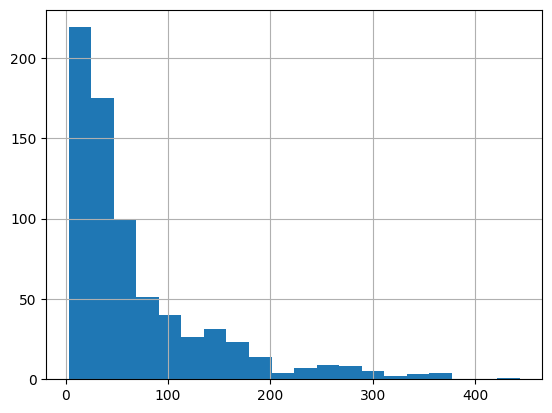

In [65]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [66]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [67]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [68]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [69]:
existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
remake_card_document(existing_cards)
existing_cards.head(10)

Cards found: 722
Total card age: 49552.08


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
611,Vocab,Jane Eyre\nPalliate\n(PAL-ee-ate) To alleviate...,1b4ba4fa445c6146a8e802c100ea4ab3,309.092472,56.240847,309.092472,6242.73407,0.599904
612,Vocab,"Well of Lost Plots, Fforde\nHomburg hat\nnoun ...",f118690dfa21e440d0a1df501ab1f622,287.215331,56.240847,309.092472,6242.73407,0.599904
613,Vocab,Jane Eyre\nSpoony\n(SPOO-nee) Foolishly or ove...,8efa6b9d9f9059532bae4f4db76976cf,279.474320,56.240847,309.092472,6242.73407,0.599904
614,Vocab,Lost in a Good Book\nCornice: An architectural...,3ef9fbd4c829dd9812bdf66a0c8be3af,272.639127,56.240847,309.092472,6242.73407,0.599904
615,Vocab,Structured Credit Combines Debt Instruments:\n...,af0e5a3f47055378bd538ee792913f17,239.605020,56.240847,309.092472,6242.73407,0.599904
617,Vocab,Do Androids Dream of Electric Sheep?\nThalamic...,6f6436ff34556183abf431b6d6ff4e9b,197.621689,56.240847,309.092472,6242.73407,0.599904
616,Vocab,Structured Credit Includes Products like CLOs ...,ba16c203dde80e3619a217a4d9f72260,197.008475,56.240847,309.092472,6242.73407,0.599904
618,Vocab,"Well of Lost Plots, Fforde\nReigate\nnoun | RY...",ea7311db7ab366d8a04c166f79592837,180.160987,56.240847,309.092472,6242.73407,0.599904
620,Vocab,Jane Eyre\nContumelious Epithet\n(con-too-MEE-...,f7901b1172d667d37e55e9900036f071,157.925647,56.240847,309.092472,6242.73407,0.599904
619,Vocab,Jane Eyre\nPiquant\n(PEE-kahnt) Having a pleas...,26188fb5cd4f1a533bc70082c0967bc2,156.888067,56.240847,309.092472,6242.73407,0.599904


## Header with oldest cards first

In [70]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [71]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [72]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [73]:
# n=10
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [74]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [75]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [76]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [77]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [78]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
610,Azure Developer Associate,You can pull container images from Azure Conta...,d3c3fa54b8227ecfb15e18b69bf5afa3,2.794837,92.628311,341.884800,5650.326981,0.153716
608,Azure Developer Associate,Type of Azure Container Registry authenticatio...,479458e1b339f5153c380c9b5d3d9922,4.225455,92.628311,341.884800,5650.326981,0.153716
606,Azure Developer Associate,Let's say you have compute workloads deployed ...,ac85c9e8d85ce50be39201db139bc927,4.286299,92.628311,341.884800,5650.326981,0.153716
607,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,4.308634,92.628311,341.884800,5650.326981,0.153716
719,Vocab,"Jingo, Pratchett\nEquerry\nnoun | EK-wuh-ree\n...",e70e016f2f6d24855ab61927dd4dbef6,4.395833,56.240847,309.092472,6242.734070,0.599904
718,Vocab,"Something Rotten, Fforde\nCoriolanus\nnoun | k...",36d5828bbf54955119829d60eaf66e9b,5.170660,56.240847,309.092472,6242.734070,0.599904
549,PnP PowerShell,Token Expiry\nThe duration an OAuth 2.0 access...,a25882e335343da6802e2a0689de2780,5.389304,75.831014,377.155088,4549.860869,0.779675
716,Vocab,"Jingo, Pratchett\nPro tem\nadverb/adjective | ...",112b5b88bfde51d68292c8520c9d9436,5.871545,56.240847,309.092472,6242.734070,0.599904
395,VMWare,Type 2 Hypervisor\n\nA hypervisor that runs on...,682c04042ddd52a15c48b98dc0a701f5,5.997792,17.422883,37.893201,749.183968,0.645782
605,Azure Developer Associate,Geo-replication enables a container registry t...,339c20d5e16e08f63569052309b38f5e,6.035330,92.628311,341.884800,5650.326981,0.153716


In [79]:
existing_cards.head(10).sum()

head                   VocabVocabVocabVocabVocabVocabVocabVocabVocabV...
body                   Jane Eyre\nPalliate\n(PAL-ee-ate) To alleviate...
hash                   1b4ba4fa445c6146a8e802c100ea4ab3f118690dfa21e4...
age                                                          2277.631134
subject_mean_age                                              562.408475
subject_highest_age                                          3090.924718
subject_age_sum                                             62427.340697
head_random_roll                                                5.999036
dtype: object

In [80]:
existing_cards['age'].mean()

68.63168707591798